In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import stan 

import arviz as az 

import nest_asyncio
nest_asyncio.apply()

In [3]:
DISPLAY_X, DISPLAY_Y = 2560, 1080

In [4]:
# Read in the data
dataset = pd.read_csv('data/full_data2.csv', usecols=['Lap_Number', 'Subject', 'Gaze.x.', 'Gaze.y.', 'Ang_Pos'], sep=';')
dataset = dataset.dropna()

Dataset:

* Timestamp
* Lap_Number (0,1)
* Position.x., Position.y., Position.z. (drone position in world)
* Orientation.y. (0-360, yaw rotation)
* Gaze_Location.x., .y., .z. (original 3D gaze point)
* Subject
* Gaze.x. (0-2560, screen-relative gaze coord)
* Gaze.y. (0-1080, screen-relative gaze coord)
* d_ang (change in Orientation.y.)
* ang_accel (change in d_ang)
* Gate_N (Upcoming gate #, can substitute for gaze point)
* Gate.x., .z. (Gate_N position in world)
* Ang_Pos (0:360, angle between Orientation.y. and normal vector of upcoming gate)

In [80]:
dataset.head(5)
dataset.shape

(194758, 5)

(-0.5, 0.5)

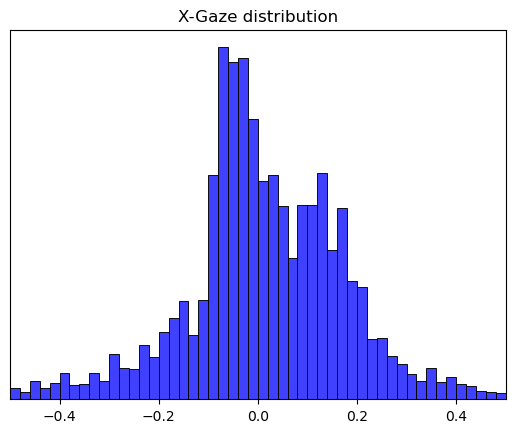

In [5]:
fig, ax = plt.subplots()
sns.histplot((dataset['Gaze.x.']/2560-0.5), bins=50, color='blue', legend=False)
plt.yticks([])
plt.xlabel("")
plt.ylabel("")
plt.title("X-Gaze distribution")
ax.set_xlim(-0.5, 0.5)

(-0.5, 0.5)

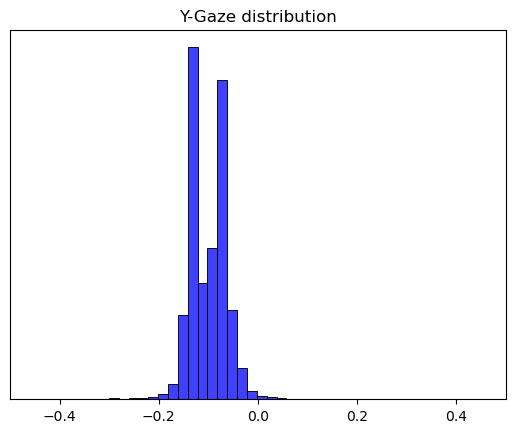

In [61]:
fig, ax = plt.subplots()
sns.histplot((dataset['Gaze.y.']/1080-0.5), bins=50, color='blue', legend=False)
plt.yticks([])
plt.xlabel("")
plt.ylabel("")
plt.title("Y-Gaze distribution")
ax.set_xlim(-0.5, 0.5)

(-0.5, 0.5)

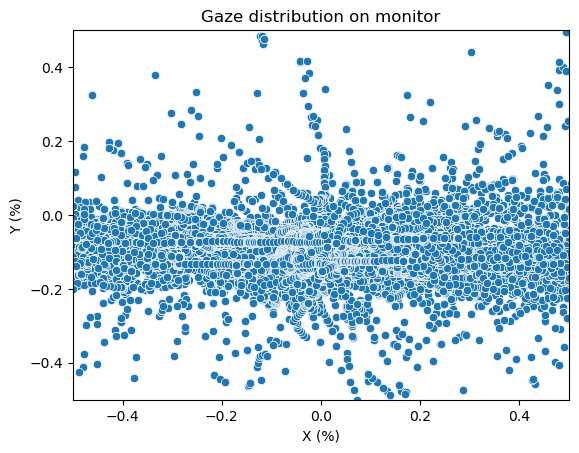

In [5]:
fig, ax = plt.subplots()
sns.scatterplot(x=(dataset['Gaze.x.']/2560-0.5), y=(dataset['Gaze.y.']/1080-0.5))
plt.title("Gaze distribution on monitor")
plt.xlabel("X (%)")
plt.ylabel("Y (%)")
ax.set_xlim(-0.5, 0.5)
ax.set_ylim(-0.5, 0.5)

(-0.5, 0.5)

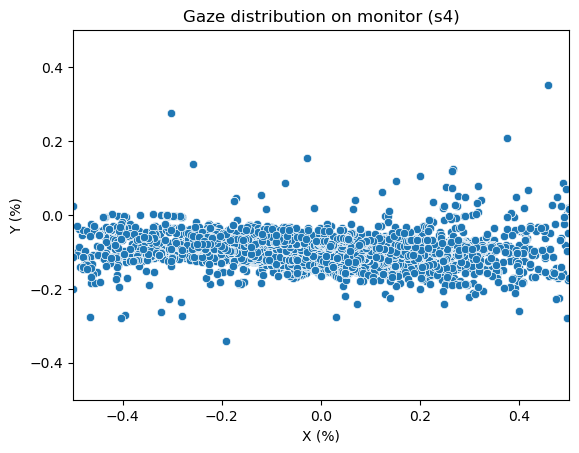

In [10]:
one = dataset[dataset.Subject==4]
fig, ax = plt.subplots()
sns.scatterplot(x=(one['Gaze.x.']/2560-0.5), y=(one['Gaze.y.']/1080-0.5))
plt.title("Gaze distribution on monitor (s4)")
plt.xlabel("X (%)")
plt.ylabel("Y (%)")
ax.set_xlim(-0.5, 0.5)
ax.set_ylim(-0.5, 0.5)

Since the dataset is so large, we subset to grab only one lap from each subject, and every tenth frame.

In [5]:
train_set = dataset[dataset.Lap_Number==1]
train_set = train_set.iloc[::10, :]

train_set.shape

(9585, 5)

In [6]:
## Normalizing the data
train_set.loc[:,'Gaze.x.'] = train_set.loc[:,'Gaze.x.'] / DISPLAY_X - 0.5
train_set.loc[:,'Gaze.y.'] = train_set.loc[:,'Gaze.y.'] / DISPLAY_Y - 0.5

## Hierarchical Linear Regression

\begin{align}
    p_{n,j} &\sim \mathcal{N}(\alpha_{j[n]} + \mu_{j[n]} + \beta_{j[n]}x_n, \sigma).
\end{align}

In [7]:
gaze_code = """

data {
    int<lower=1> N; // Number of samples
    int<lower=1> J; // Number of subjects
    array[N] int<lower=1, upper=J> mask;
    
    vector[N] angles; // Ang_Pos
    vector[N] x; // Gaze.x.
    vector[N] y; // Gaze.y.
}

parameters {
    real<lower=0> sigma_x;
    real<lower=0> sigma_y;
    real<lower=0> tau;
    
    real alpha_x;
    real alpha_y;
    
    real beta_x;
    real beta_y;
    
    vector[J] u;
}

model {

    // Level 1 Priors
    sigma_x ~ gamma(2, 2);
    sigma_y ~ gamma(0.5, 5);
    tau ~ cauchy (0, 5);
    
    alpha_x ~ normal(0, 5);
    alpha_y ~ normal(0, 5);
    
    beta_x ~ normal(0, 10);
    beta_y ~ normal(0, 10);
    
    // Level 2 Priors
    u ~ normal(0, tau);

    // Likelihood
    for (n in 1:N) {
        x[n] ~ normal(alpha_x + u[mask[n]] + angles[n] * beta_x, sigma_x);
        y[n] ~ normal(alpha_y + u[mask[n]] + angles[n] * beta_y, sigma_y);
    }
}

generated quantities {
    array[N, 2] real pred_gaze;

    for (n in 1:N) {
        pred_gaze[n, 1] = normal_rng(alpha_x + u[mask[n]] + angles[n] * beta_x, sigma_x);
        pred_gaze[n, 2] = normal_rng(alpha_y + u[mask[n]] + angles[n] * beta_y, sigma_y);
    }
}
"""

In [8]:
## Assemble stan-friendly data dictionary
data_dict = {
    'N': train_set.shape[0],
    'J': np.unique(train_set.Subject).shape[0],
    'mask': train_set['Subject'].to_numpy(),
    'angles': train_set['Ang_Pos'].to_numpy(),
    'x': train_set['Gaze.x.'].to_numpy(),
    'y': train_set['Gaze.y.'].to_numpy()
}

In [9]:
gaze_model = stan.build(program_code=gaze_code, data=data_dict)

Building: found in cache, done.


In [81]:
gaze_fit = gaze_model.sample(num_chains=4, num_warmup=1000, num_samples=2000)

Sampling:   0%
Sampling:   0% (1/12000)
Sampling:   0% (2/12000)
Sampling:   0% (3/12000)
Sampling:   0% (4/12000)
Sampling:   1% (103/12000)
Sampling:   2% (202/12000)
Sampling:   3% (301/12000)
Sampling:   3% (400/12000)
Sampling:   4% (500/12000)
Sampling:   5% (600/12000)
Sampling:   6% (700/12000)
Sampling:   7% (800/12000)
Sampling:   8% (900/12000)
Sampling:   8% (1000/12000)
Sampling:   9% (1100/12000)
Sampling:  10% (1200/12000)
Sampling:  11% (1300/12000)
Sampling:  12% (1400/12000)
Sampling:  12% (1500/12000)
Sampling:  13% (1600/12000)
Sampling:  14% (1700/12000)
Sampling:  15% (1800/12000)
Sampling:  16% (1900/12000)
Sampling:  17% (2000/12000)
Sampling:  18% (2100/12000)
Sampling:  18% (2200/12000)
Sampling:  19% (2300/12000)
Sampling:  20% (2400/12000)
Sampling:  21% (2500/12000)
Sampling:  22% (2600/12000)
Sampling:  22% (2700/12000)
Sampling:  23% (2800/12000)
Sampling:  24% (2900/12000)
Sampling:  25% (3001/12000)
Sampling:  26% (3101/12000)
Sampling:  27% (3201/12000

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: gamma_lpdf: Random variable is inf, but must be positive finite! (in '/tmp/httpstan_ab9cnlyt/model_kunnvxln.stan', line 30, column 4 to column 26)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Gradient evaluation took 0.006194 seconds
  1000 transitions using 10 leapfrog steps per transition would take 61.94 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be

  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: gamma_lpdf: Random variable is inf, but must be positive finite! (in '/tmp/httpstan_ab9cnlyt/model_kunnvxln.stan', line 30, column 4 to column 26)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: gamma_lpdf: Random variable is inf, but must be positive finite! (in '/tmp/httpstan_ab9cnlyt/model_kunnvxln.stan', line 30, column 4 to column 26)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance ma

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: gamma_lpdf: Random variable is inf, but must be positive finite! (in '/tmp/httpstan_ab9cnlyt/model_kunnvxln.stan', line 31, column 4 to column 28)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.


Here we check efficiency, convergence, and some values

In [18]:
summary = az.summary(gaze_fit)

In [15]:
summary.head(7)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma_x,0.164,0.001,0.162,0.166,0.0,0.0,3237.0,3796.0,1.0
sigma_y,0.026,0.000,0.026,0.027,0.0,0.0,2865.0,3701.0,1.0
tau,0.005,0.001,0.003,0.007,0.0,0.0,3048.0,3522.0,1.0
alpha_x,0.032,0.003,0.027,0.038,0.0,0.0,3285.0,4031.0,1.0
alpha_y,-0.072,0.001,-0.074,-0.069,0.0,0.0,1997.0,2307.0,1.0
beta_x,-0.003,0.000,-0.004,-0.002,0.0,0.0,6340.0,6308.0,1.0
beta_y,-0.000,0.000,-0.000,-0.000,0.0,0.0,8567.0,6207.0,1.0


Then check our parameter values and visually check convergence

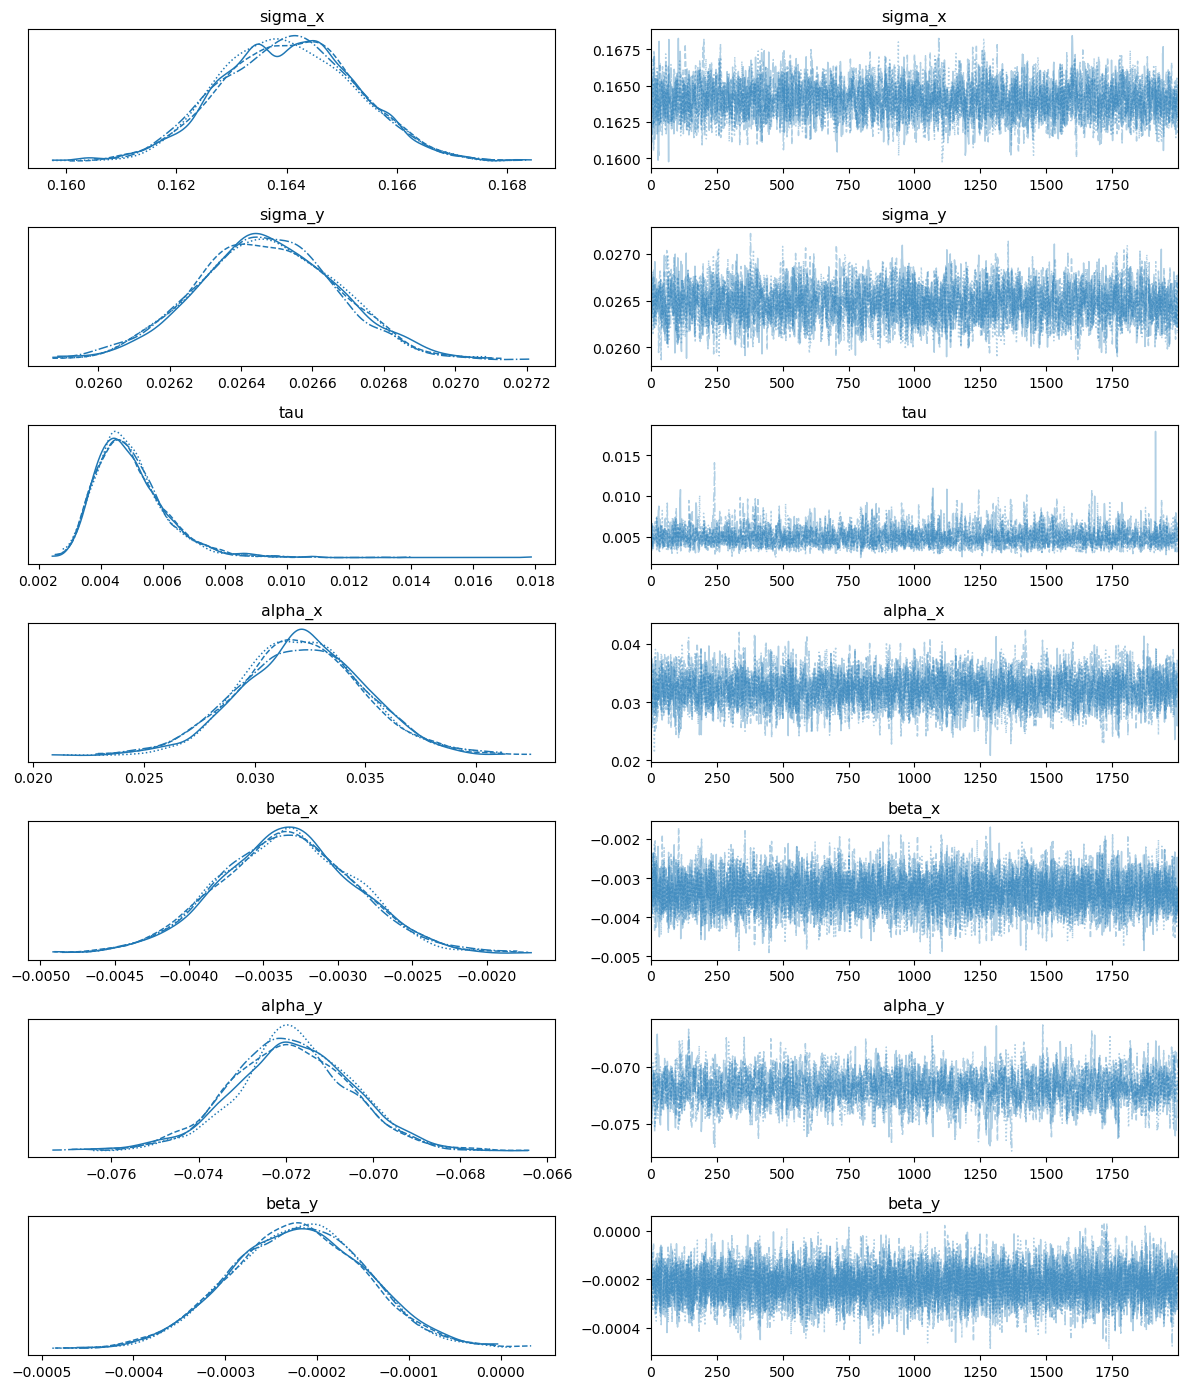

In [14]:
az.plot_trace(gaze_fit, var_names=['sigma_x', 'sigma_y', 'tau', 'alpha_x', 'beta_x', 'alpha_y', 'beta_y'])
plt.tight_layout()

Finally, grab the predicted gaze data and compare it to actual gaze data.

In [82]:
results = gaze_fit.to_frame()
start = (results.shape[1] - train_set.shape[0] * 2)
results = results.iloc[:, start:]

In [30]:
results.shape

(8000, 19170)

(-0.5, 0.5)

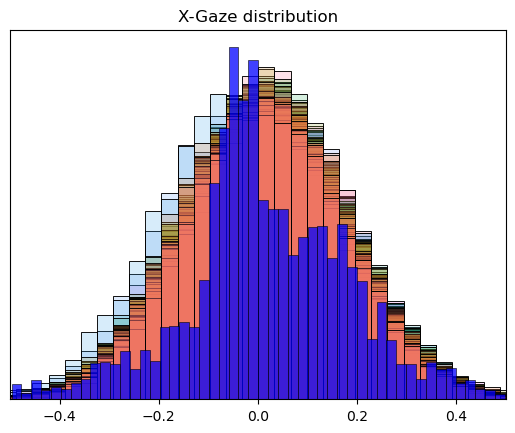

In [53]:
fig, ax = plt.subplots()
sns.histplot(results.iloc[:,100:200], bins=50, alpha=0.2, legend=False)
sns.histplot(train_set['Gaze.x.'], bins=50, color='blue', legend=False)
plt.yticks([])
plt.xlabel("")
plt.ylabel("")
plt.title("X-Gaze distribution")
ax.set_xlim(-0.5, 0.5)

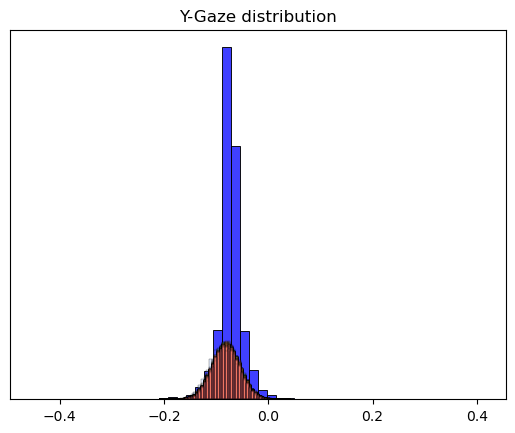

In [54]:
fig, ax = plt.subplots()
sns.histplot(train_set['Gaze.y.'], bins=50, color='blue', legend=False)
sns.histplot(results.iloc[:,10000:10100], bins=50, alpha=0.2, legend=False)
plt.yticks([])
plt.xlabel("")
plt.ylabel("")
plt.title("Y-Gaze distribution")
ax.xlim=(-0.5, 0.5)

(-0.5, 0.5)

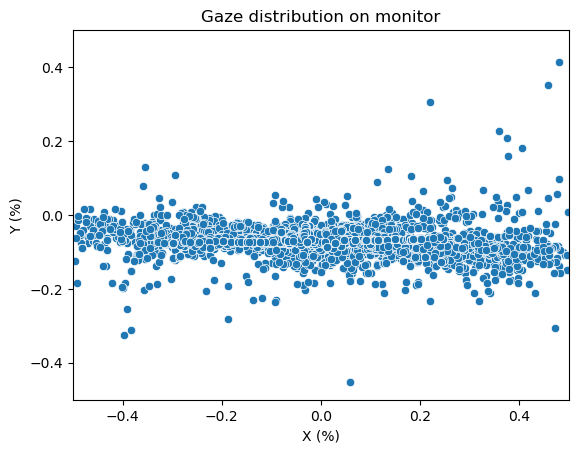

In [57]:
fig, ax = plt.subplots()
sns.scatterplot(x=train_set['Gaze.x.'], y=train_set['Gaze.y.'])
plt.title("Gaze distribution on monitor")
plt.xlabel("X (%)")
plt.ylabel("Y (%)")
ax.set_xlim(-0.5, 0.5)
ax.set_ylim(-0.5, 0.5)

(-0.5, 0.5)

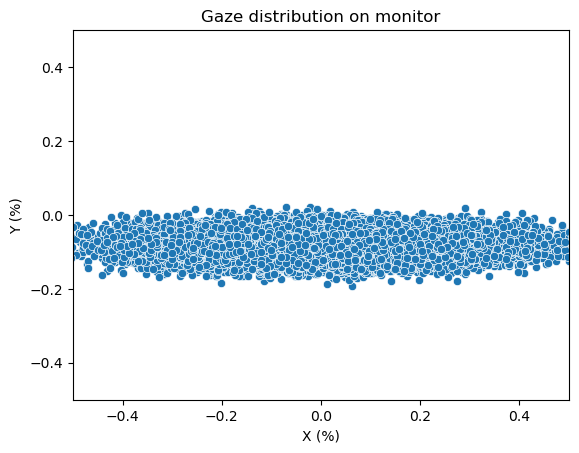

In [90]:
fig, ax = plt.subplots()
sns.scatterplot(x=results.iloc[1:100,100:500].values.flatten(), y=results.iloc[1:100,9700:10100].values.flatten())
plt.title("Gaze distribution on monitor")
plt.xlabel("X (%)")
plt.ylabel("Y (%)")
ax.set_xlim(-0.5, 0.5)
ax.set_ylim(-0.5, 0.5)

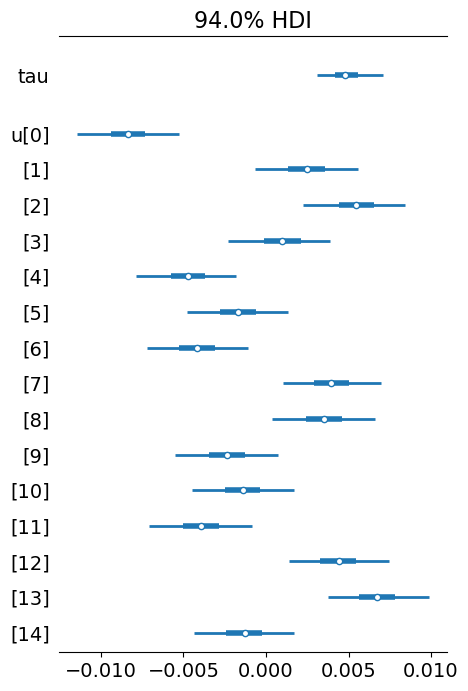

In [33]:
axes = az.plot_forest(
    gaze_fit,
    var_names=['u'],
    filter_vars='like',
    linewidth=2,
    combined=True,
    ridgeplot_overlap=1.5,
    figsize=(5, 8),
)

Text(0.5, 1.0, 'Generative Performance: X')

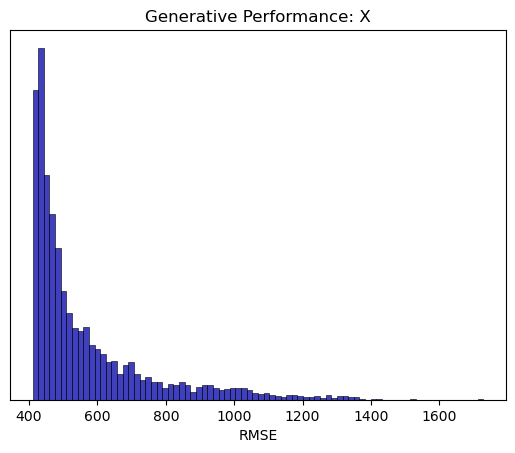

In [83]:
x1 = (results.iloc[:, :9585].values + 0.5) * 2560
x2 = (train_set.iloc[:, 2].values + 0.5) * 2560

f, ax = plt.subplots()
sns.histplot(np.sqrt(np.mean((x1 - x2)**2, axis=0)), color='#0000AA', ax=ax)
ax.set_yticks([])
ax.set_ylabel('')
ax.set_xlabel('RMSE', fontsize=10)
ax.set_title('Generative Performance: X')

(0.0, 100.0)

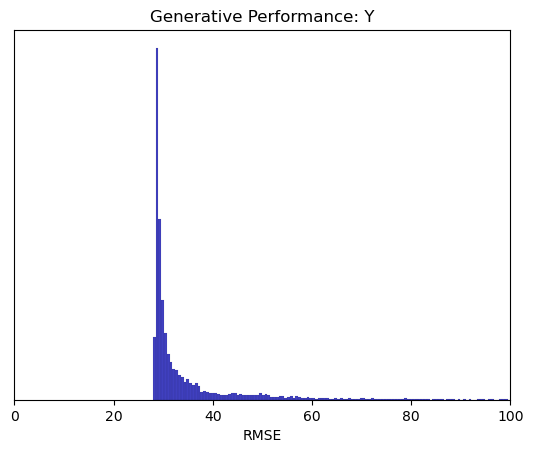

In [84]:
y1 = (results.iloc[:, 9585:].values + 0.5) * 1080
y2 = (train_set.iloc[:, 3].values + 0.5) * 1080

f, ax = plt.subplots()
sns.histplot(np.sqrt(np.mean((y1 - y2)**2, axis=0)), color='#0000AA', ax=ax)
ax.set_yticks([])
ax.set_ylabel('')
ax.set_xlabel('RMSE', fontsize=10)
ax.set_title('Generative Performance: Y')
ax.set_xlim(0, 100)